# Model checking and evaluation

In [1]:
import csv
import re
import numpy
import scipy.stats 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA = "data.csv"
RESULTS = [
    ["Normal", "results-Normal.csv"], 
    ["LogNormal", "results-LogNormal.csv"], 
    ["HierLogNormal", "results-HierLogNormal.csv"]
]

## The Data

Text(0.5, 0, 'observations')

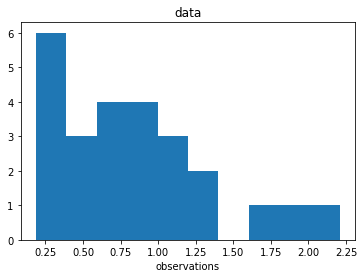

In [3]:
data = numpy.genfromtxt(DATA)
_ = plt.hist(data)
plt.title("data")
plt.xlabel("observations")

## The Posterior

For analysis here, we will use the posterior for model checking. We will need samples and the log-probability at the mean, to compute DIC.

In [4]:
def posterior(result):
    """returns array of samples from the posterior"""
    samples = []
    atmean = None
    with open(result) as f:
        rdr = csv.reader(f)
        next(rdr)
        for rec in rdr:
            mu, sigma, logp = float(rec[1]), float(rec[2]), float(rec[-1])
            if rec[0]=="sample":
                samples.append([mu, sigma, logp])
            elif rec[0]=="mean":
                atmean = [mu, sigma, logp]
    return numpy.array(samples), atmean

In [5]:
SAMPLES = []
for model, result in RESULTS:
    samples, atmean = posterior(result)
    SAMPLES.append([model, samples, atmean])

Let us visualize the posteriors. Posteriors for LogNormal, and HierLogNormal should look similar, in the posterior for normal the values of mu and sigma will be different because the sampling distribution is Normal rather than log-Normal.

We can roughly assess convergence by looking at the histogram of logp (with log scale on the y axis). The histogram edge should obviously form a straight (diagonal) line on the graph. If it is far from the diagonal, the samples do not reliably represent the posterior.

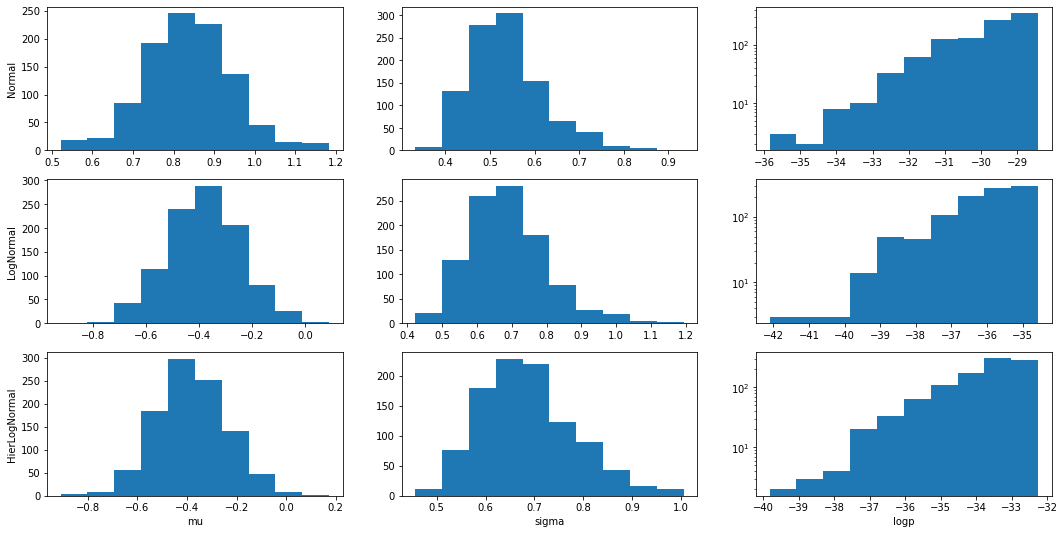

In [6]:
fig, ax = plt.subplots(3,3, figsize=(18, 9))
ax[-1][0].set_xlabel("mu")
ax[-1][1].set_xlabel("sigma")
ax[-1][2].set_xlabel("logp")
for i, (model, samples, _) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    ax[i][2].set_yscale("log")
    for j in range(3):
        ax[i][j].hist(samples[:, j])

We will need conditional samplers to draw observations from the posterior. LogNormal and HierLogNormal use the same sampler.

In [7]:
def draw_from_normal(mu, sigma, size=1):
    """draws a sample from normal model"""
    return scipy.stats.norm.rvs(loc=mu, scale=sigma, size=size)

def draw_from_log_normal(mu, sigma, size=1):
    """draws a sample from log-normal model"""
    return scipy.stats.lognorm.rvs(s=sigma, scale=numpy.exp(mu), size=size)

draw_from = {
    "Normal": draw_from_normal,
    "LogNormal": draw_from_log_normal,
    "HierLogNormal": draw_from_log_normal
}

## Model Checking

To check that the model suits the data, we'll check the median and the extreme values (quantiles or other metrics can be checked too, as demonstrated in the book). For that, we'll first compute the extreme values for the data, and then compare them against  simulated extreme values with each of the models.

In [8]:
dataMin, dataMax, dataMedian = data.min(), data.max(), numpy.median(data)
print(f"min:\t{dataMin:.3f}\nmax:\t{dataMax:.3f}\nmedian:\t{dataMedian:.3f}")

min:	0.186
max:	2.211
median:	0.735


We will now draw multiple simulations of the data set from the posteriors. 

In [9]:
def simulate(samples, draw, nobs=len(data)):
        simulation = []
        for iobs in range(nobs):
            i = numpy.random.randint(len(samples))
            mu, sigma = samples[i,[0, 1]]
            simulation.append(draw(mu, sigma)[0])
        return numpy.array(simulation)

Just for illustration, we plot overlaid histograms of  data and 3 simulations from each of the models. This informal check suggests quality of fit of each the models.

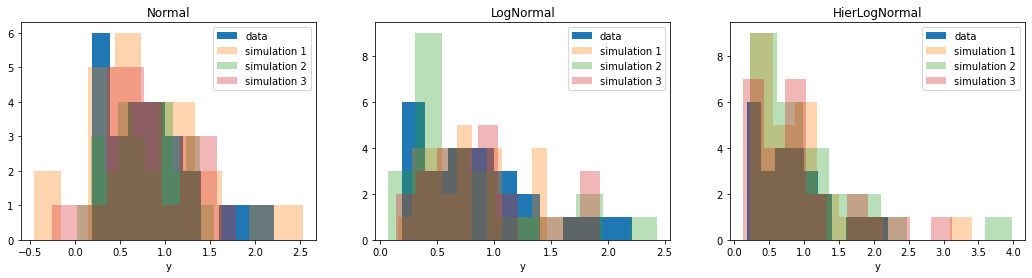

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for i, (model, samples, _) in enumerate(SAMPLES):
    ax[i].set_title(model)
    ax[i].set_xlabel("y")
    ax[i].hist(data, label="data")
    for j in range(3):
        ax[i].hist(simulate(samples, draw_from[model]), alpha=0.33, label="simulation "+str(j+1))
    ax[i].legend()

We will now generate 100 simulations from each model, and plot histograms of minimum, maximum, and median for each model, with marks for the values for observations for comparison (red vertical lines).

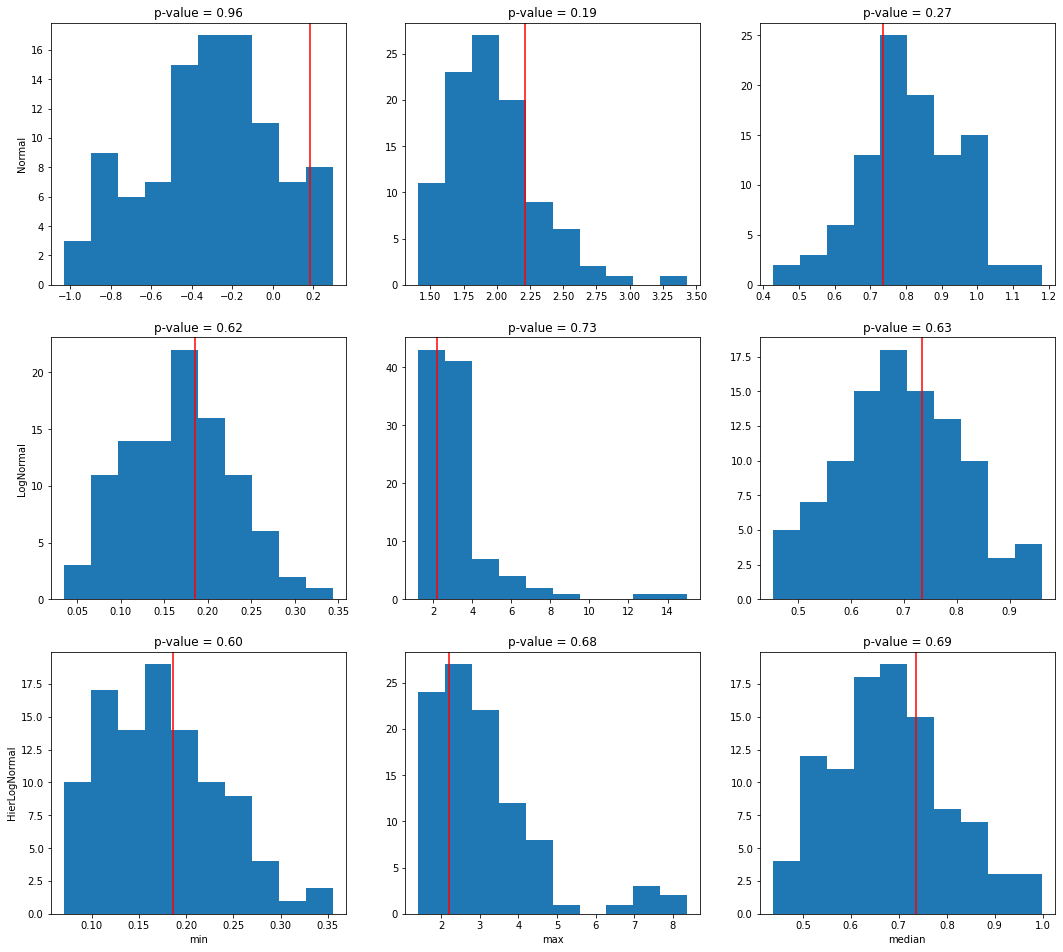

In [11]:
NSIM = 100
fig, ax = plt.subplots(3, 3, figsize=(18, 9))
fig.subplots_adjust(top=1.5)
ax[-1][0].set_xlabel("min")
ax[-1][1].set_xlabel("max")
ax[-1][2].set_xlabel("median")
for i, (model, samples, _) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    min_max_median = []
    for j in range(NSIM):
        y = simulate(samples, draw_from[model])
        min_max_median.append([y.min(), y.max(), numpy.median(y)])
    min_max_median = numpy.array(min_max_median)
    
    # plot data values of test variables as vertical red lines
    ax[i][0].axvline(dataMin, color="red")
    ax[i][1].axvline(dataMax, color="red")
    ax[i][2].axvline(dataMedian, color="red")
    
    # plot sampled values of test values as histograms
    for j in range(3):
        ax[i][j].hist(min_max_median[:, j], zorder=-1)
    
    # compute p-values and display them as subplot titles
    ax[i][0].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 0][min_max_median[:, 0] < dataMin]) /
        len(min_max_median)))
    ax[i][1].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 1][min_max_median[:, 1] > dataMax]) /
        len(min_max_median)))
    ax[i][2].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 2][min_max_median[:, 2] < dataMedian]) /
        len(min_max_median)))

One can see that the normal model does not pass the three-point check: most minima are too small, the median is off, and most maxima are too high. The log-normal models suit better, HierLogNormal looks better overall but that may be just to a better luck in the posterior sample, which is rather small.

## Evaluation

We evaluate models by computing information criteria, or by cross-validation. In this study, we will use DIC (deviance information criterion) to evaluate and compare models. We use equation (7.10) to compute $p_{DIC}$.

In [12]:
def DIC(samples, atmean):
    lpd = atmean[-1]
    p = 2*numpy.var(samples[:, -1])
    return -2*(lpd - p)

In [13]:
for i, (model, samples, atmean) in enumerate(SAMPLES):
    print("{:>16}: {:.1f}".format(model, DIC(samples, atmean)))

          Normal: 62.8
       LogNormal: 75.1
   HierLogNormal: 70.5


What we see here is that the normal model gets the best score (apparently due to better modelling of high-probability values) but we know from model checking that it must be rejected if we are interested in the tails.

HierLogNormal achieves an improvement over LogNormal model, due to an additional parameter. This may actually be due to better convergence due to overspecifciation.